# Pre-layout signal integrity
This example shows how to create a parameterized layout design
and load the layout into HFSS 3D Layout for analysis and postprocessing.

- Create EDB:

    - Add material.
    - Create stackup.
    - Create a parameterized via padstack definition.
    - Create ground planes.
    - Create a component.
    - Create signal vias and traces.
    - Create ground stitching vias.
    - Create HFSS analysis setup and frequency sweep.

- Import EDB into HFSS 3D Layout:

    - Place SMA connector.
    - Analyze.
    - Plot return loss.

Here is an image of the model that is created in this example.

<img src="_static/pre_layout_sma_connector_on_pcb.png" width="600">

Keywords: **HFSS 3D Layout**, **signal integrity**.

## Perform imports and define constants
Perform required packages.

In [1]:
import os
import tempfile
import time

from ansys.aedt.core import Hfss3dLayout
from ansys.aedt.core.examples.downloads import download_file
from pyedb import Edb


Define constants.

In [2]:
AEDT_VERSION = "2025.2"
NUM_CORES = 4
NG_MODE = False  # Open AEDT UI when it is launched.

## Create temporary directory and download example files

Create a temporary directory where downloaded data or
dumped data can be stored.
If you'd like to retrieve the project data for subsequent use,
the temporary folder name is given by ``temp_folder.name``.

In [3]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")
sma_rf_connector = download_file(
    source="component_3d",
    name="SMA_RF_SURFACE_MOUNT.a3dcomp",
    local_path=temp_folder.name,
)

# Create layout design

## Import example design

In [4]:
aedb = os.path.join(temp_folder.name, "new_layout.aedb")
edbapp = Edb(edbpath=aedb, edbversion=AEDT_VERSION)

C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\misc\decorators.py:55: UserWarning: Argument `edbversion` is deprecated for method `Edb`; use `version` instead.
  warnings.warn(
C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\generic\design_types.py:301: UserWarning: Your ANSYS AEDT version is eligible to gRPC version.You might consider switching to that version for better user experience.For more information please check this link: https://edb.docs.pyansys.com/version/dev/grpc_api/index.html
  warnings.warn(GRPC_GENERAL_WARNING, UserWarning)


PyEDB INFO: Star initializing Edb 12:16:36.520078


PyEDB INFO: Edb version 2025.2


PyEDB INFO: Logger is initialized. Log file is saved to C:\Users\ansys\AppData\Local\Temp\pyedb_ansys.log.


PyEDB INFO: legacy v0.67.1


PyEDB INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyEDB INFO: create_edb completed in 8.6000 seconds.


PyEDB INFO: EDB C:\Users\ansys\AppData\Local\Temp\tmp24coi8nw.ansys\new_layout.aedb created correctly.


PyEDB INFO: EDB initialization completed in 8.6815 seconds.


In [5]:
# Set antipad always on.
edbapp.design_options.antipads_always_on = True

## Add material definitions

In [6]:
edbapp.materials.add_conductor_material(name="copper", conductivity=58000000)
edbapp.materials.add_dielectric_material(
    name="FR4_epoxy", permittivity=4, dielectric_loss_tangent=0.02
)
edbapp.materials.add_dielectric_material(
    name="solder_mask", permittivity=3.1, dielectric_loss_tangent=0.035
)

## Create stackup

In [7]:
edbapp.stackup.create_symmetric_stackup(
    layer_count=4,
    inner_layer_thickness="18um",
    outer_layer_thickness="50um",
    dielectric_thickness="100um",
    dielectric_material="FR4_epoxy",
    soldermask=True,
    soldermask_thickness="20um",
)

True

## Create parameterized padstack definition

Create signal via padstack definition.

In [8]:
edbapp["$antipad"] = "0.7mm"
edbapp.padstacks.create(
    padstackname="svia", holediam="0.3mm", antipaddiam="$antipad", paddiam="0.5mm"
)

PyEDB INFO: Padstack svia create correctly


'svia'

Create component pin padstack definition.

In [9]:
edbapp.padstacks.create(
    padstackname="comp_pin",
    paddiam="400um",
    antipaddiam="600um",
    start_layer="TOP",
    stop_layer="TOP",
    antipad_shape="Circle",
    has_hole=False,
)

PyEDB INFO: Padstack comp_pin create correctly


'comp_pin'

## Review stackup

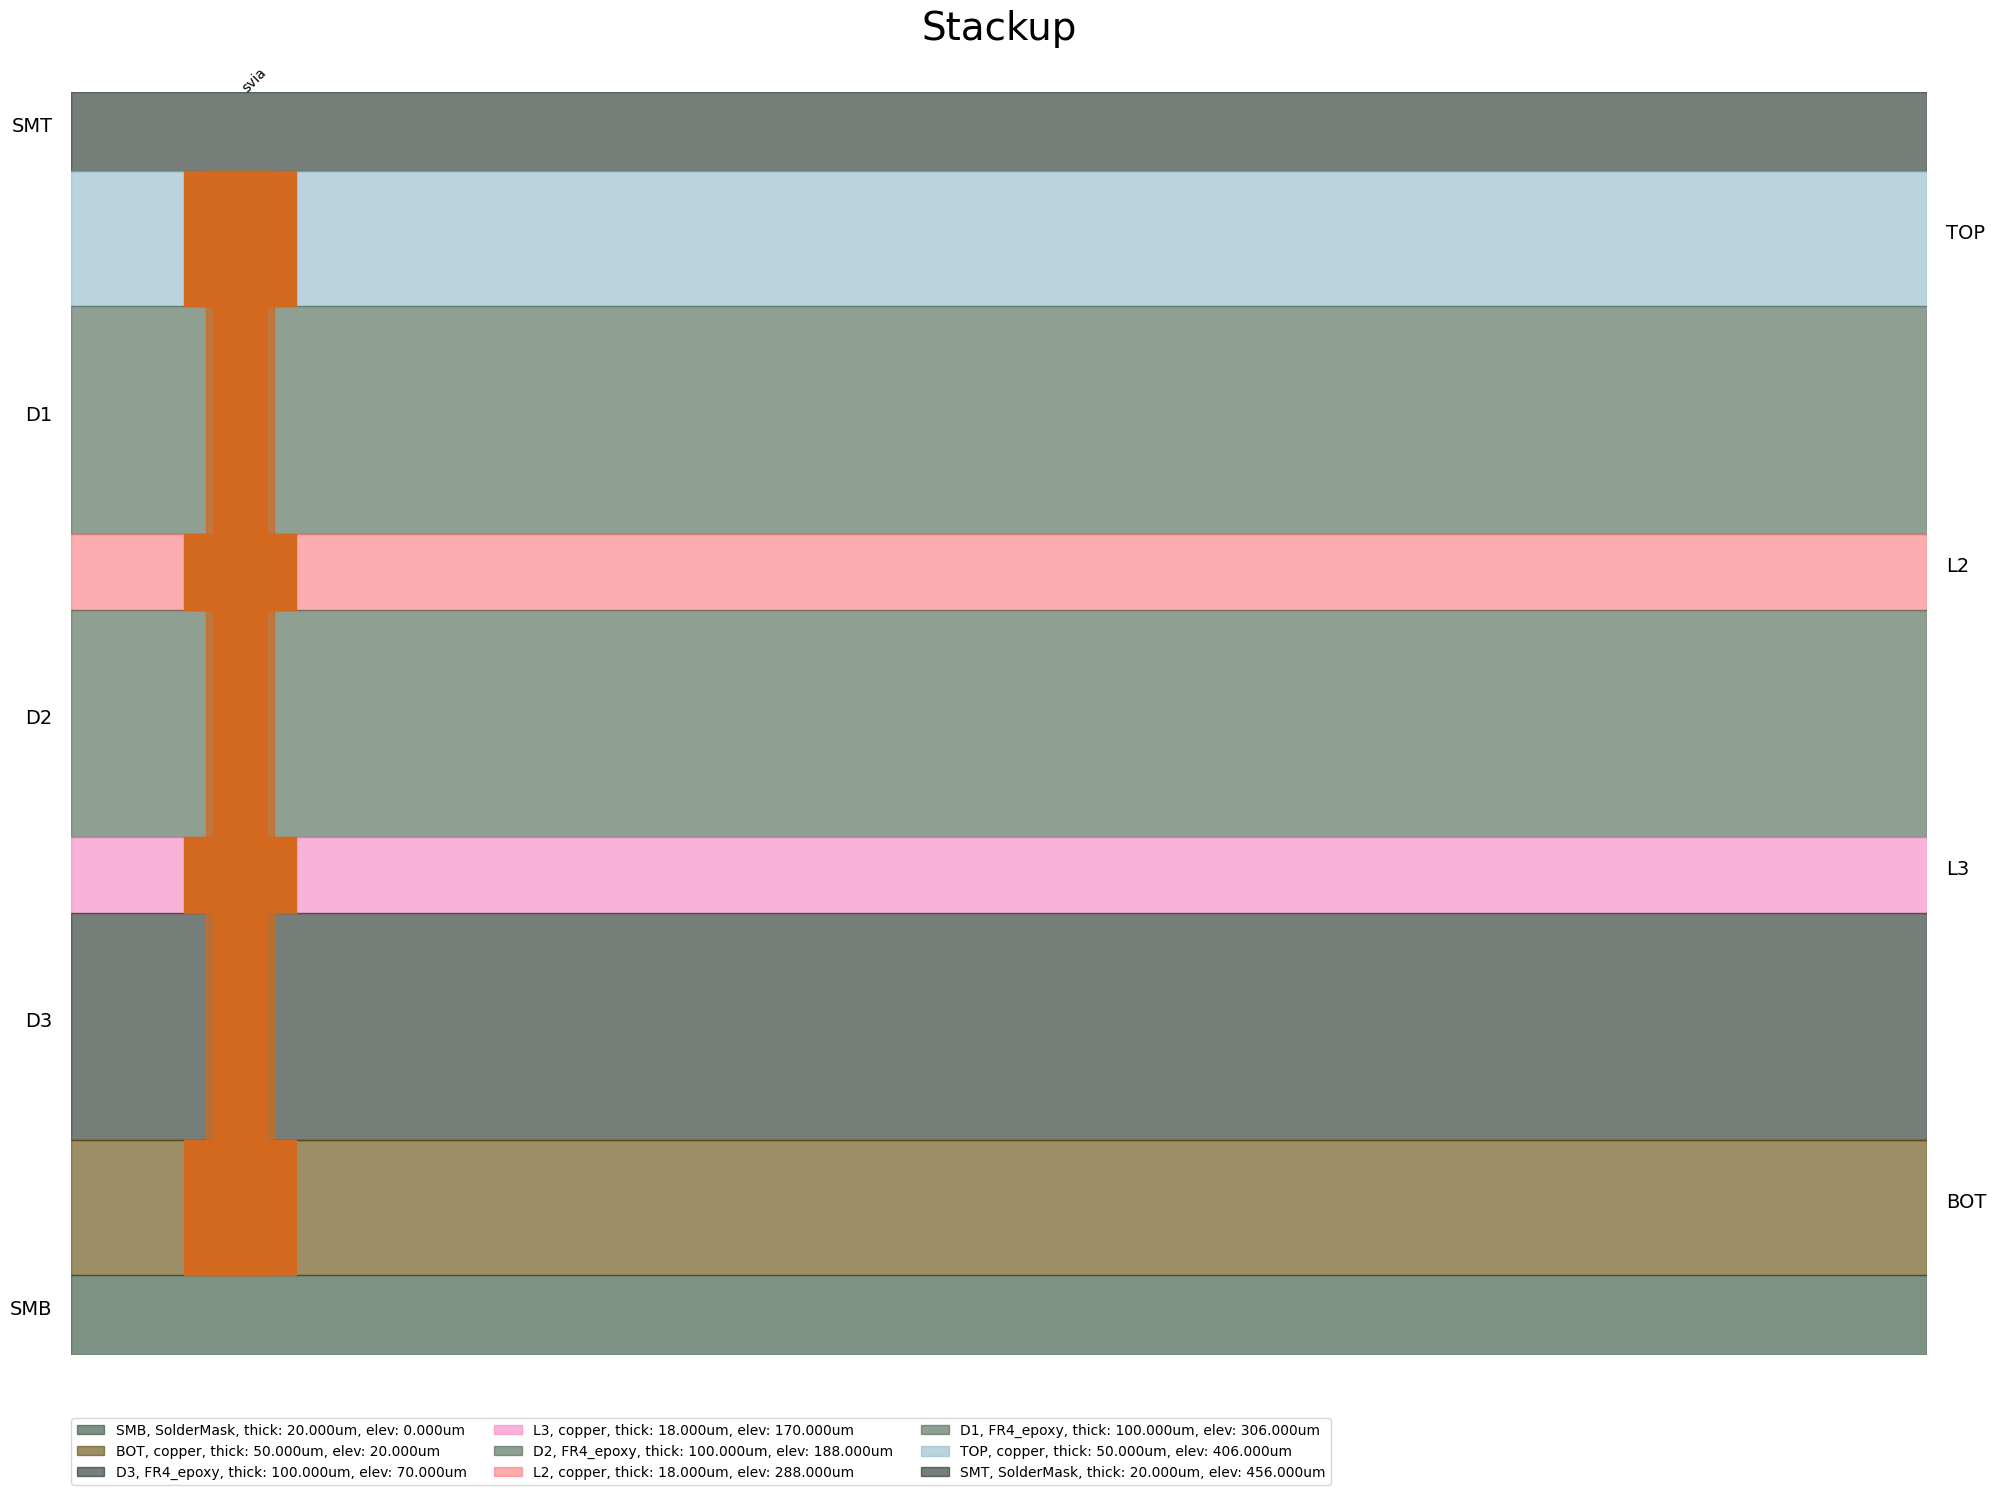

<module 'matplotlib.pyplot' from 'C:\\actions-runner\\_work\\pyaedt-examples\\pyaedt-examples\\.venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [10]:
edbapp.stackup.plot(plot_definitions="svia")

## Create ground planes

In [11]:
board_width = "22mm"
board_length = "18mm"
board_center_point = [0, "5mm"]

gnd_l2 = edbapp.modeler.create_rectangle(
    layer_name="L2",
    net_name="GND",
    center_point=board_center_point,
    width=board_width,
    height=board_length,
    representation_type="CenterWidthHeight",
    corner_radius="0mm",
    rotation="0deg",
)

gnd_l3 = edbapp.modeler.create_rectangle(
    layer_name="L3",
    net_name="GND",
    center_point=board_center_point,
    width=board_width,
    height=board_length,
    representation_type="CenterWidthHeight",
    corner_radius="0mm",
    rotation="0deg",
)

gnd_bottom = edbapp.modeler.create_rectangle(
    layer_name="BOT",
    net_name="GND",
    center_point=board_center_point,
    width=board_width,
    height=board_length,
    representation_type="CenterWidthHeight",
    corner_radius="0mm",
    rotation="0deg",
)

## Create a component

In [12]:
edbapp.padstacks.place(
    position=[0, 0],
    definition_name="comp_pin",
    net_name="SIG",
    is_pin=True,
    via_name="1",
)

In [13]:
comp_pins = [
    edbapp.padstacks.place(
        position=["-6mm", 0],
        definition_name="comp_pin",
        net_name="GND",
        is_pin=True,
        via_name="2",
    ),
    edbapp.padstacks.place(
        position=["6mm", 0],
        definition_name="comp_pin",
        net_name="GND",
        is_pin=True,
        via_name="3",
    ),
]

In [14]:
comp_u1 = edbapp.components.create(
    pins=comp_pins,
    component_name="U1",
    component_part_name="BGA",
    placement_layer="TOP",
)
comp_u1.create_clearance_on_component(extra_soldermask_clearance=3.5e-3)

PyEDB INFO: Correctly computed Extension at first iteration.


True

## Place vias

Place a signal via.

In [15]:
edbapp.padstacks.place(
    position=[0, 0], definition_name="svia", net_name="SIG", is_pin=False
)

Place ground stitching vias.

In [16]:
edbapp.padstacks.place(
    position=["-1mm", 0], definition_name="svia", net_name="GND", is_pin=False
)
edbapp.padstacks.place(
    position=["1mm", 0], definition_name="svia", net_name="GND", is_pin=False
)
edbapp.padstacks.place(
    position=[0, "-1mm"], definition_name="svia", net_name="GND", is_pin=False
)
edbapp.padstacks.place(
    position=[0, "1mm"], definition_name="svia", net_name="GND", is_pin=False
)

## Create signal traces

In [17]:
edbapp["width"] = "0.15mm"
edbapp["gap"] = "0.1mm"

Create signal fanout.

In [18]:
sig_trace = edbapp.modeler.create_trace(
    path_list=[[0, 0]],
    layer_name="BOT",
    width="width",
    net_name="SIG",
    start_cap_style="Round",
    end_cap_style="Round",
    corner_style="Round",
)

In [19]:
sig_trace.add_point(x="0.5mm", y="0.5mm", incremental=True)
sig_trace.add_point(x=0, y="1mm", incremental=True)
sig_trace.add_point(x="-0.5mm", y="0.5mm", incremental=True)
sig_trace.add_point(x=0, y="1mm", incremental=True)
sig_path = sig_trace.get_center_line()

Create coplanar waveguide with ground with ground stitching vias.

In [20]:
sig2_trace = edbapp.modeler.create_trace(
    path_list=[sig_path[-1]],
    layer_name="BOT",
    width="width",
    net_name="SIG",
    start_cap_style="Round",
    end_cap_style="Flat",
    corner_style="Round",
)
sig2_trace.add_point(x=0, y="6mm", incremental=True)
sig2_trace.create_via_fence(distance="0.5mm", gap="1mm", padstack_name="svia")
sig2_trace.add_point(x=0, y="1mm", incremental=True)

True

Create trace-to-ground clearance.

In [21]:
sig2_path = sig2_trace.get_center_line()
path_list = [sig_path, sig2_path]
for i in path_list:
    void = edbapp.modeler.create_trace(
        path_list=i,
        layer_name="BOT",
        width="width+gap*2",
        start_cap_style="Round",
        end_cap_style="Round",
        corner_style="Round",
    )
    edbapp.modeler.add_void(shape=gnd_bottom, void_shape=void)

Generate plot to review.

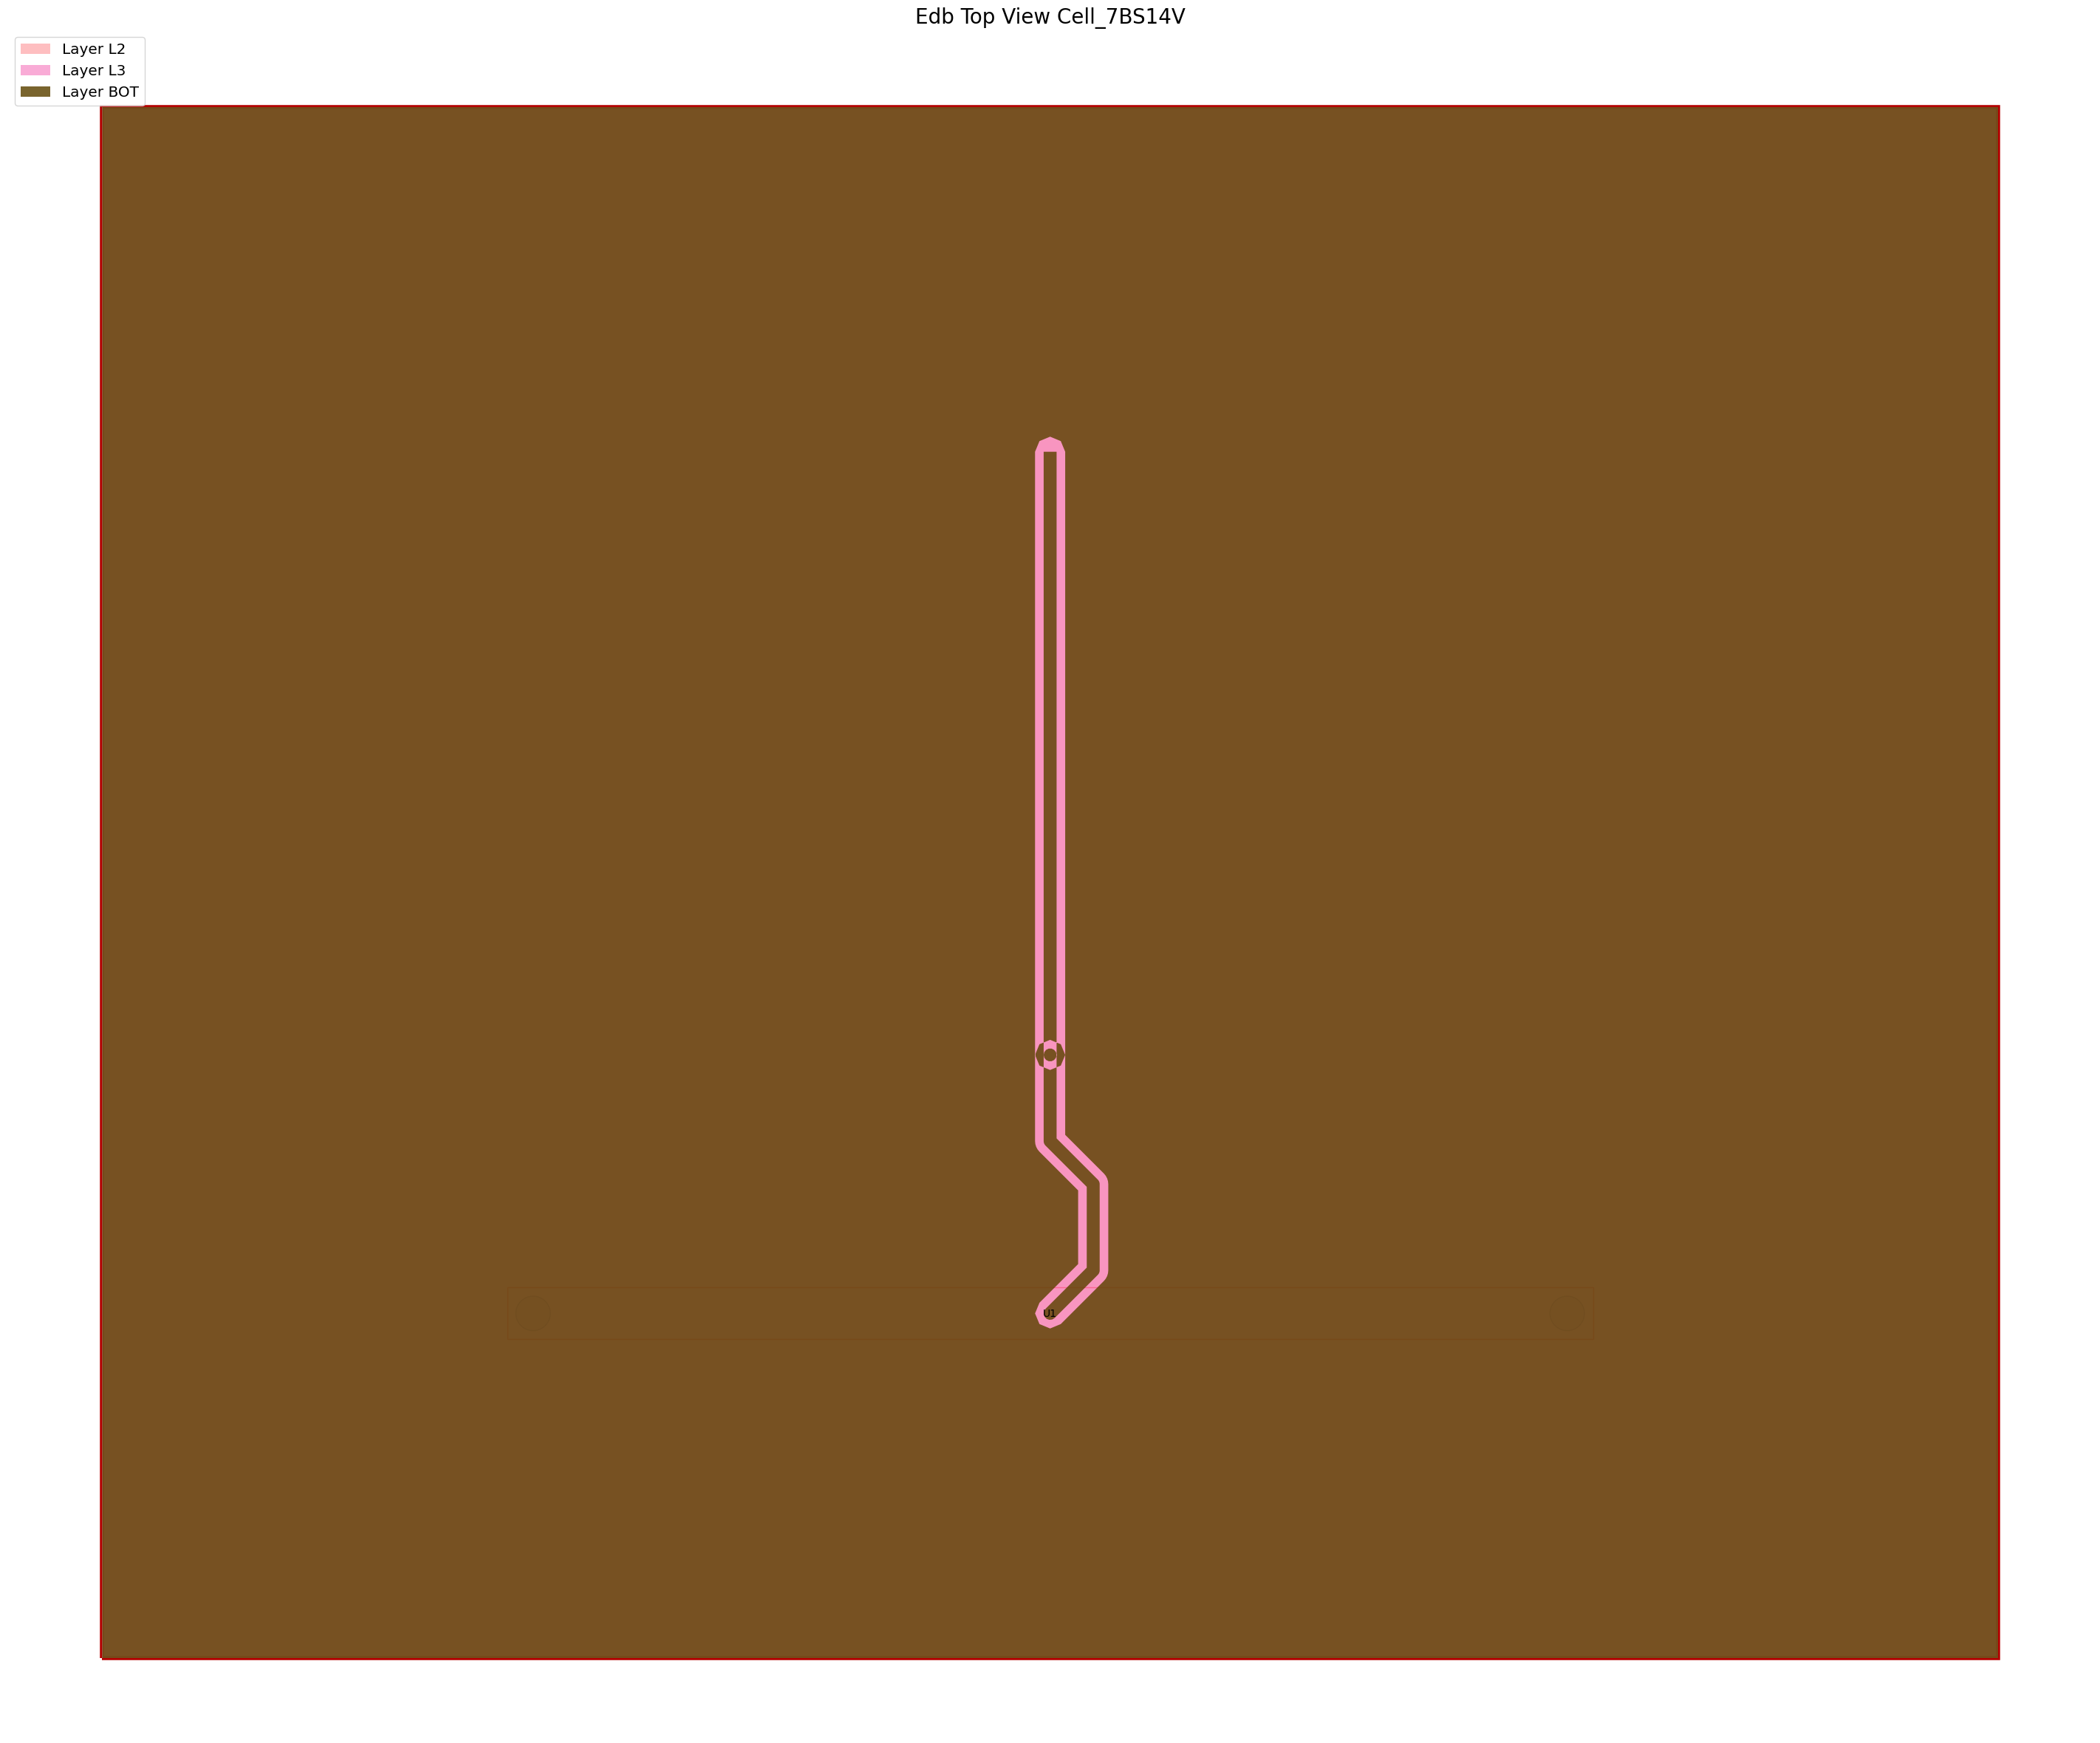

PyEDB INFO: Plot Generation time 0.505


(<Figure size 6000x3000 with 1 Axes>,
 <Axes: title={'center': 'Edb Top View Cell_7BS14V'}>)

In [22]:
edbapp.nets.plot()

## Create ports

Create a wave port.

In [23]:
sig2_trace.create_edge_port(
    name="p1_wave_port",
    position="End",
    port_type="Wave",
    reference_layer=None,
    horizontal_extent_factor=10,
    vertical_extent_factor=10,
    pec_launch_width="0.01mm",
)

('p1_wave_port',
 <pyedb.dotnet.database.edb_data.ports.WavePort at 0x28717f5e290>)

## Create HFSS analysis setup

In [24]:
setup = edbapp.create_hfss_setup("Setup1")
setup.set_solution_single_frequency("5GHz", max_num_passes=1, max_delta_s="0.02")
setup.hfss_solver_settings.order_basis = "first"

Add a frequency sweep to the setup.

When the simulation results are to
be used for transient SPICE analysis, you should
use the following strategy:

- DC point
- Logarithmic sweep from 1 kHz to 100 MHz
- Linear scale for higher frequencies

In [25]:
setup.add_frequency_sweep(
    "Sweep1",
    frequency_sweep=[
        ["log scale", "10MHz", "100MHz", 3],
        ["linear scale", "0.1GHz", "5GHz", "0.2GHz"],
    ],
)

## Save and close EDB

In [26]:
edbapp.save()
edbapp.close()

PyEDB INFO: Save Edb file completed in 0.0000 seconds.


PyEDB INFO: Close Edb file completed in 0.0451 seconds.


True

# Analyze in HFSS 3D Layout

## Load EDB into HFSS 3D Layout.

In [27]:
h3d = Hfss3dLayout(aedb, version=AEDT_VERSION, non_graphical=NG_MODE, new_desktop=True)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)].


PyAEDT INFO: PyAEDT version 0.25.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_e691762a-9a70-4736-b50d-cacab9a7ce0c.log is enabled.


PyAEDT INFO: Log on AEDT is disabled.


PyAEDT INFO: Starting new AEDT gRPC session.


PyAEDT INFO: AEDT installation Path C:\Program Files\ANSYS Inc\v252\AnsysEM


PyAEDT INFO: Client application successfully started.


PyAEDT INFO: New AEDT gRPC session session started on port 50051.


PyAEDT INFO: 2025.2 version started with process ID 7708.


PyAEDT WARNING: Service Pack is not detected. PyAEDT is currently connecting in Insecure Mode.


PyAEDT WARNING: Please download and install latest Service Pack to use connect to AEDT in Secure Mode.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: EDB folder C:\Users\ansys\AppData\Local\Temp\tmp24coi8nw.ansys\new_layout.aedb has been imported to project new_layout


PyAEDT INFO: Active Design set to 0;Cell_7BS14V


PyAEDT INFO: Active Design set to 0;Cell_7BS14V


PyAEDT INFO: Aedt Objects correctly read


## Place SMA RF connector

In [28]:
comp = h3d.modeler.place_3d_component(
    component_path=sma_rf_connector,
    number_of_terminals=1,
    placement_layer="TOP",
    component_name="sma_rf",
    pos_x=0,
    pos_y=0,
    create_ports=True,
)
comp.angle = "90deg"

PyAEDT INFO: Loading Modeler.


PyAEDT INFO: Modeler loaded.


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


## Run simulation

In [29]:
h3d.analyze(num_cores=4)

False

## Visualize the return loss.

In [30]:
h3d.post.create_report("dB(S(port_1, port_1))")

PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmp24coi8nw.ansys\new_layout.aedt.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmp24coi8nw.ansys\new_layout.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.03147172927856445


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


PyEDB INFO: Star initializing Edb 12:17:22.670519


PyEDB INFO: Edb version 2025.2


PyEDB INFO: Logger is initialized. Log file is saved to C:\Users\ansys\AppData\Local\Temp\pyedb_ansys.log.


PyEDB INFO: legacy v0.67.1


PyEDB INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyEDB INFO: Database new_layout.aedb Opened in 2025.2


PyEDB INFO: Cell Cell_7BS14V Opened


PyEDB INFO: Builder was initialized.


PyEDB INFO: open_edb completed in 0.0157 seconds.


PyEDB INFO: EDB initialization completed in 0.0157 seconds.


PyAEDT INFO: EDB loaded.


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\generic\design_types.py:301: UserWarning: Your ANSYS AEDT version is eligible to gRPC version.You might consider switching to that version for better user experience.For more information please check this link: https://edb.docs.pyansys.com/version/dev/grpc_api/index.html
  warnings.warn(GRPC_GENERAL_WARNING, UserWarning)


PyAEDT ERROR: Failed to create traces on the report. Check input parameters


False

-

## Create Field Plot on clip plane

In [31]:
# solutions = h3d.get_touchstone_data()[0]
# solutions.log_x = False
# solutions.plot()
cp_name = h3d.modeler.clip_plane()

In [32]:
plot = h3d.post.create_fieldplot_cutplane(
    cp_name, "Mag_E", h3d.nominal_adaptive, intrinsics={"Freq": "5GHz", "Phase": "0deg"}
)

PyAEDT INFO: Active Design set to 0;Cell_7BS14V


## Release AEDT

In [33]:
h3d.save_project()
h3d.release_desktop()
# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Project new_layout Saved correctly


PyAEDT INFO: Desktop has been released and closed.


## Clean up

All project files are saved in the folder ``temp_dir.name``.
If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell
removes all temporary files, including the project folder.

In [34]:
temp_folder.cleanup()